In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
plt.style.use('seaborn')

Our goal is to create a lending strategy that is both profitable and fair.

## Table Of Contents:
1. [EDA and Data Cleaning](#eda)
    1. [Load data](#load)
    2. [clean loan_status](#loan_status)
    3. [create profit feature](#profit)
    4. [drop sparse features](#drop_missing)
    5. [drop features coming after the loan attribution](#drop_temporal)
    6. [create binary features](#binary)
    7. [remove text features](#text)
    8. [clean Object features](#clean_object)
    9. [merge census data](#centroid)
    10. [impute missing values](#impute)
    11. [engineer feature : expected_profit](#expected_profit)
    12. [create cleaning pipeline](#cleaning_pipeline)
    13. [EDA on Census Data](#eda_census)
    
2. [Black Box Models](#black_box)
    1. [linear model](#linear)
    2. [linear model + lasso](#lasso)
    3. [linear model + ridge](#ridge)
    4. [Random Forest](#rf)
    5. [XGBoost](#xgboost)

3. [Visualize Results](#plots)
    1. [summary](#summary)
    2. [focus on XG Boost](#focus_xg)
    3. [feature importance](#feature_importance)

4. [Fairness](#fairness)
    2. [protected classes](#protected)
    3. [fair linear model](#fair_linear)
    4. [fair mlp](#fair_mlp)

## EDA and Data Cleaning <a name="eda"></a>

## Load Accepted Loans Data <a name="load"></a>

First we load the accepted loans dataset that we accessed [here](https://www.lendingclub.com/info/download-data.action). This data set contains all loans from 2007 to 2018.

In [146]:
accepted_df = pd.read_csv("../../data/rawData/full/fullAccepted.csv", error_bad_lines=False)

b'Skipping line 42537: expected 145 fields, saw 289\n'
b'Skipping line 85073: expected 145 fields, saw 289\n'
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [281]:
accepted_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,NaN,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648.0,83.70%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62,NaN,Oct-18,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,NaN,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687.0,9.40%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66,NaN,Oct-16,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [282]:
len(accepted_df)

2174792

## Measuring Profitability  

Let's explore the `loan_status` columns.  <a name="loan_status"></a>

Text(0.5,1,'Number of loans per loan status')

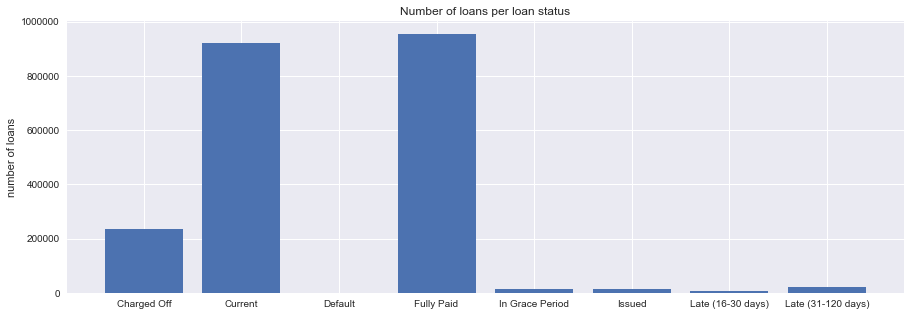

In [283]:
plt.figure(figsize=(15,5))
plt.bar(accepted_df.groupby('loan_status').size().index, accepted_df.groupby('loan_status').size())
plt.ylabel('number of loans')
plt.title('Number of loans per loan status')

Observations:
* Most of the loans are either fully paid or current. We will not take account of the late loans given that they do not contribute substantially to the dataset
* From the [information](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-) on lending club's website, there are 3 completed loan categories in our dataset: Charged Off, Fully Paid, and Default. 

**Remove ongoing loans**

To measure profitability of a loan, we will first need to remove the current loans. As we saw above, this means we need to keep records with the `loan_status` Charged Off, Fully Paid, or Default.

In [284]:
def remove_current_loans(df):
    df = df[(df.loan_status == "Fully Paid") | (df.loan_status == "Charged Off") | (df.loan_status == "Default")]
    return df
df = remove_current_loans(accepted_df)
len(df)

1191198

This leaves us with 1,191,198 records - still a lot! To speed up our analysis, we will sample 25 000 current loans and 25 000 charged off / default loans to make up our training data. We balance the classes to make sure that our regression doesn't ignore the defaulted loans since they make up a minority of all loans. However, we do not balance our data for our test set because we're ultimately interested in profitability of our model and we don't want to artificially inflate the number of loans that are defaulted on. For our EDA, we'll ignore the test data and return to it when we do our modelling.

In [285]:
def sample_data(df, samples = 25000):
    df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)
    
    #sample training data (balance classes)
    df_train_paid = df_train[df_train.loan_status == "Fully Paid"]
    df_train_unpaid = df_train[(df_train.loan_status == "Charged Off") | (df_train.loan_status == "Default")]    
    df_train = pd.concat([df_train_paid.sample(samples), df_train_unpaid.sample(samples)], axis = 0)
    
    #test data (don't balance)
    df_test = df_test.sample(samples*2)
    return df_train, df_test
df, _ = sample_data(df) # we won't worry about the test data for now
len(df)

50000

We now have a large, but manageable number of completed loans.

**Create a profit column** <a name="profit"></a>



A lender makes a profit on the interest of a loan. In other words, this is the difference between what the borrower pays and the total size of the loan (since the fees provided to LendingClub are negligible). To calculate the profit, we subtract the `total_pymt_inv` and `funded_amnt`.

In [286]:
def calculate_profit(df):
    df['profit'] = df['total_pymnt_inv'] - df['funded_amnt']
    return df
df = calculate_profit(df)

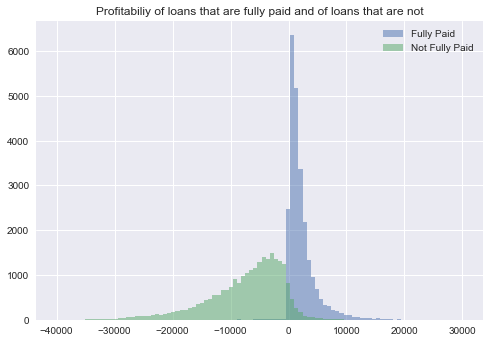

In [287]:
plt.hist(df[df.loan_status == 'Fully Paid'].profit, bins = np.linspace(-40000,30000,100), alpha = 0.5, label = "Fully Paid")
plt.hist(df[df.loan_status != 'Fully Paid'].profit, bins = np.linspace(-40000,30000,100), alpha = 0.5, label = "Not Fully Paid")
plt.title("Profitabiliy of loans that are fully paid and of loans that are not")
plt.legend()
plt.show()

**observations:**
* As we would expect, the loans that are fully paid always lead to profit.
* Similarly, loans that are not fully paid usually, but not always, lead to losses.
* The distribution of defaulted loans has a fatter tail than the distribution of paid loans.



We can compute the total profit made by the company, less the loans that are currently being processed : 

In [288]:
total_profit = df['profit'].sum()
print('total profit made by the company with accepted and rejected loans only (excluding current loans )')
print(total_profit)

total profit made by the company with accepted and rejected loans only (excluding current loans )
-129042785.37999998


## Cleaning the data

**drop columns that have too many missing values** <a name="drop_missing"></a>

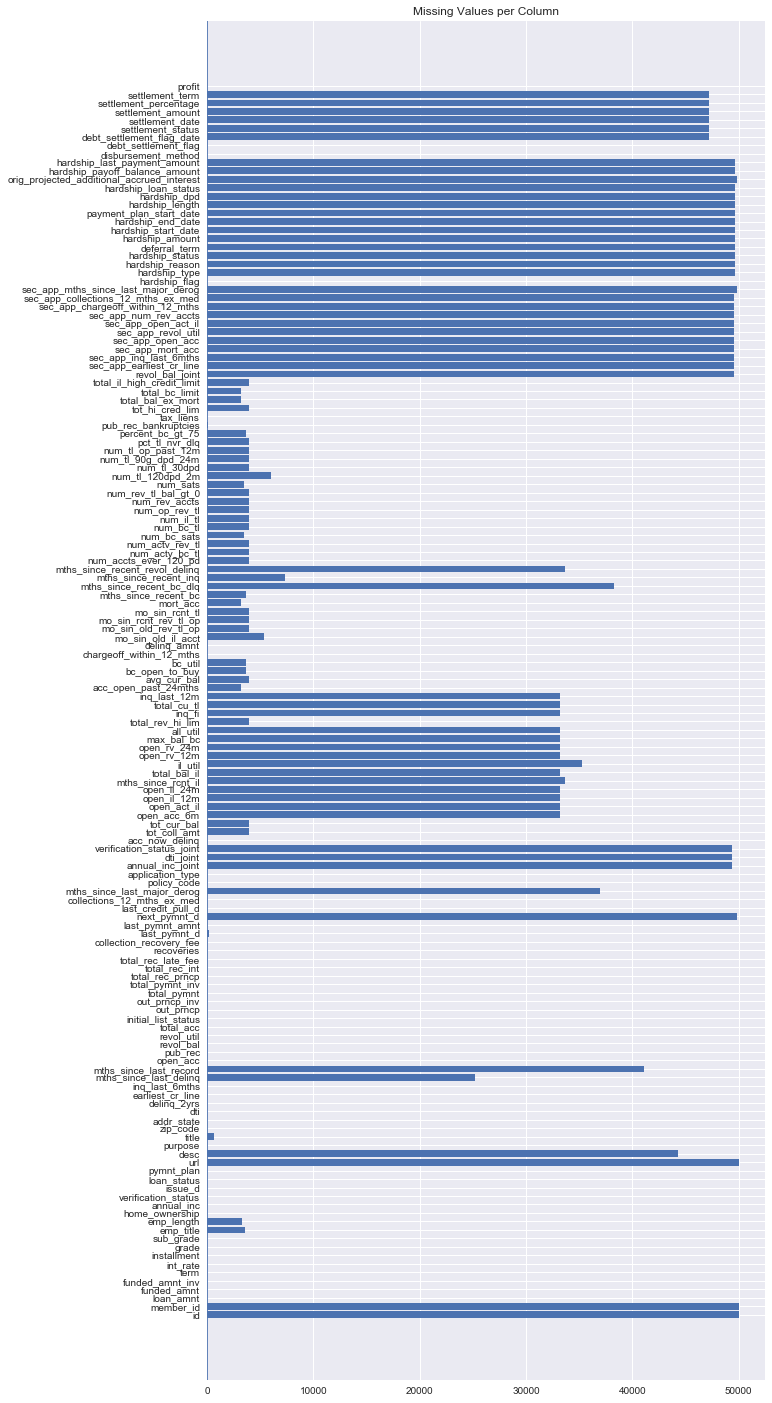

In [289]:
plt.figure(figsize=(10,25))
plt.barh(df.isna().sum().index, df.isna().sum())
plt.title("Missing Values per Column")
plt.axvline(.5)
plt.show()

There are many columns that have over half of their values missing. In a perfect world, we would use our subject matter expertise to handle these missing values. Due to the data being obtained opportunistically and our little domain knowledge, however, we will simply drop columns that have more than 50% of their values missing. We also have a large number of features so dropping some columns will make the problem more manageable.

In [156]:
print("columns before:", df.values.shape[1])
def drop_missing_cols(df):
    not_missing_cols = df.columns[df.apply(lambda x: sum(x.isna())) < 0.5*len(df)]
    return df[not_missing_cols]

df = drop_missing_cols(df)
print("columns after:", df.values.shape[1])

columns before: 146
columns after: 88


**drop columns that we would not have access to at time of investment** <a name="drop_temporal"></a>

Since we're trying to predict the profitability of new loans using completed loans, we will drop all columns that either:
1. Represent a value that's likely to change over time
2. We would not have access to at time of investment

We use the data dictionary and domain knowledge to make these decisions.

In [157]:
data_dict = pd.read_csv('../../data/AcceptedDataDictionary.csv')

data_dict

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


In [158]:
def remove_future_cols(df):
    columns_to_exclude = [
        'acc_open_past_24mths',
        'acc_now_delinq',
        'avg_cur_bal',
        'bc_open_to_buy',
        'bc_util',
        'collection_recovery_fee',
        'chargeoff_within_12_mths',
        'collections_12_mths_ex_med',
        'delinq_2yrs',
        'delinq_amnt',
        'debt_settlement_flag',
        'inq_last_6mths',
        'mo_sin_old_il_acct',
        'mo_sin_old_rev_tl_op',
        'mo_sin_rcnt_rev_tl_op',
        'mo_sin_rcnt_tl',
        'mort_acc',
        'mths_since_recent_bc',
        'mths_since_recent_inq',
        'num_accts_ever_120_pd',
        'num_actv_bc_tl',
        'num_actv_rev_tl',
        'num_rev_tl_bal_gt_0',
        'num_tl_90g_dpd_24m',
        'num_tl_120dpd_2m',
        'num_tl_op_past_12m',
        'num_tl_30dpd',
        'out_prncp',
        'out_prncp_inv',
        'pct_tl_nvr_dlq',
        'percent_bc_gt_75',
        'issue_d',
        'last_pymnt_d',
        'last_credit_pull_d',
        'pub_rec',
        'recoveries',
        'revol_bal',
        'revol_util',
        'tot_coll_amt',
        'tot_cur_bal',
        'tot_hi_cred_lim',
        'total_bal_ex_mort',
        'total_pymnt_inv',
        'funded_amnt',
        'total_pymnt', 
        'total_rec_prncp',
        'total_rec_int',
        'last_pymnt_amnt',
        'funded_amnt_inv'
    ]

    for feature_name in columns_to_exclude:
        try:
            df = df.drop(feature_name,axis = 1)
        except:
            print('the feature {} has already been removed before (not enough entries)'.format(feature_name))
    return df
print("columns before:", df.values.shape[1])
df = remove_future_cols(df)
print("columns after:", df.values.shape[1])

columns before: 88
columns after: 39


**convert binary objects to 0/1 encoding** <a name="binary"></a>

Text(0.5,1,'greater than 20 unique values')

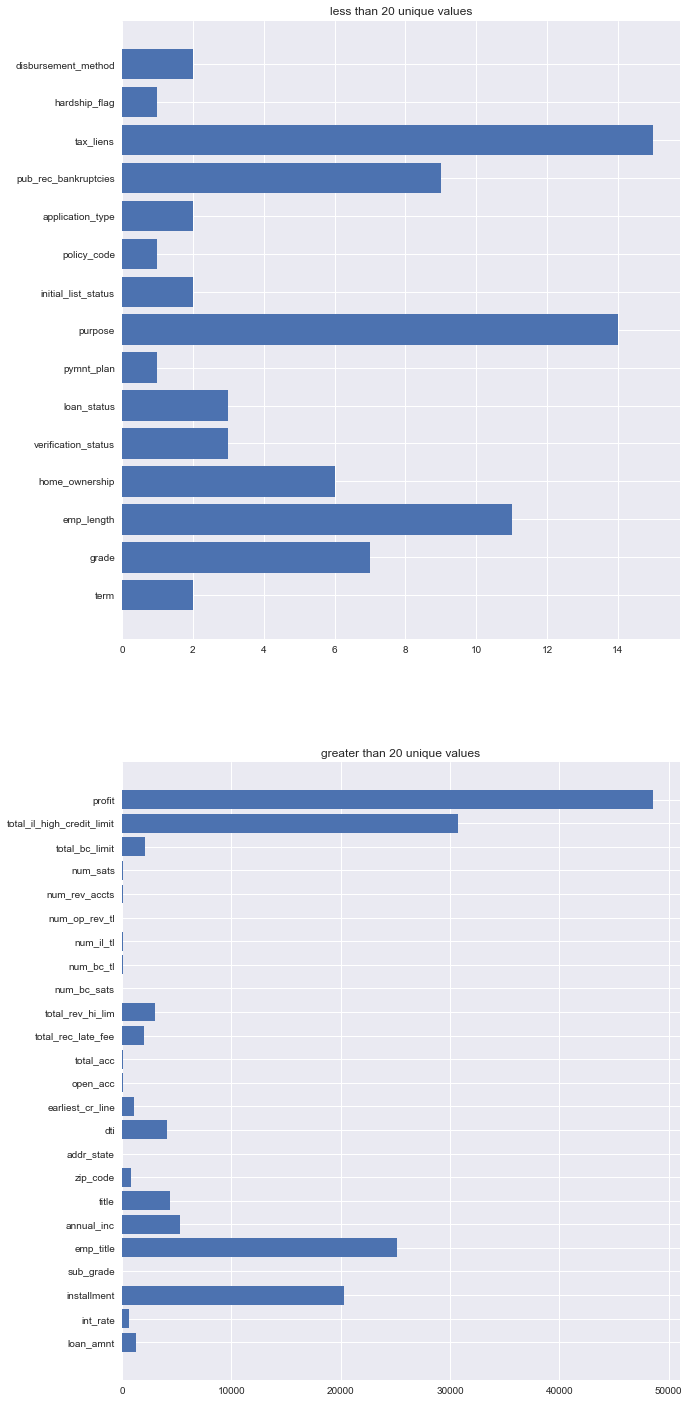

In [159]:
fig, axes = plt.subplots(2,1, figsize=(10,25))
unique = df.nunique()
threshold = 20
axes[0].barh(unique[unique<threshold].index, unique[unique<threshold])
axes[0].set_title('less than {} unique values'.format(threshold))
axes[1].barh(unique[unique>threshold].index, unique[unique>threshold])
axes[1].set_title('greater than {} unique values'.format(threshold))


Observations:
* Some columns have only 2 unique values, we will convert them 0/1 entries
* Some columns have only 1 unique value, we will drop them

In [160]:
def clean_low_unique_values(df):
    binary_cols = df.columns[(df.nunique() == 2)]
    for col in binary_cols:
        categories = df[col].dropna().unique()
        df[col] = pd.to_numeric(df[col].apply(lambda x: 1 if x == categories[0] else 0))
    df = df.drop(df.columns[(df.nunique() == 1)], axis = 1)
    return df

In [161]:
print("columns before:", df.values.shape[1])
df = clean_low_unique_values(df)
print("columns after:", df.values.shape[1])

columns before: 39
columns after: 36


**Text Columns**  <a name="text"></a>

It is beyond the scope of this problem to handle unstructured text.

In [162]:
def drop_text_col(df):
    text_cols = ['emp_title', 'title']
    df = df.drop(text_cols, axis = 1)
    return df
print("columns before:", df.values.shape[1])
df = drop_text_col(df)
print("columns after:", df.values.shape[1])

columns before: 36
columns after: 34


**Object Specific Processing**  <a name="clean_object"></a>

Text(0.5,1,'Number of columns that are floats, ints, and objects')

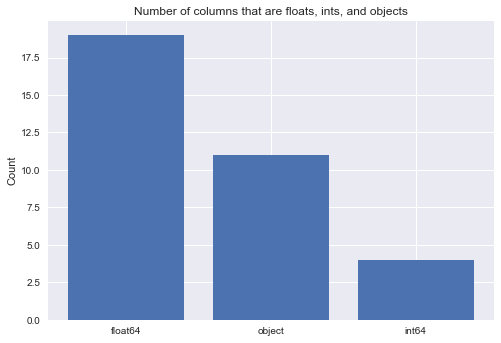

In [163]:
types = df.dtypes.value_counts()
plt.bar(types.index.astype(str), types.values)
plt.ylabel('Count')
plt.title('Number of columns that are floats, ints, and objects')

Observations:
* There are still a number of columns that are objects,

We need to handle the remaining object columns on a case-by-case basis.

**int_rate:** remove percent sign and convert to float  
**grade and subgrade:** one hot encode grade and then change the value of the encoding to the subgrade  
**emp_length:** extract number of years  
**home_ownership:** one hot encode  
**verigication_status:** one hot encode  
**loan_status:** drop  
**purpose:** one hot encode  
**zip_code:** save for fairness analysis and drop  
**addr_state:** get lat lon  
**earliest_cr_line:** represent as month since xxxxx

In [164]:
def clean_objects(data):
    # clean int_rate
    data['int_rate'] = pd.to_numeric(data['int_rate'].apply(lambda x: x.replace("%","")))
    
    # clean grade
    dummies = pd.get_dummies(data['grade'], prefix='grade')
    data = pd.concat([data, dummies], axis=1)
    data = data.drop('grade', axis=1)
    
    #clean sub_grade    
    data = data[data.sub_grade.apply(lambda x: len(x) == 2)]
    def embed_subGrade(data):
        col, val = data['sub_grade'][0], int(data['sub_grade'][1])
        data['grade_'+col]=val
        return(data)
        
    data = data.apply(embed_subGrade, axis=1)
    data = data.drop('sub_grade', axis=1)

    #clean emp_lenght        
    length_to_int = dict()
    length_to_int['< 1 year']=0
    length_to_int['1 year']=1
    length_to_int['2 years']=2
    length_to_int['3 years']=3
    length_to_int['4 years']=4
    length_to_int['5 years']=5
    length_to_int['6 years']=6
    length_to_int['7 years']=7
    length_to_int['8 years']=8
    length_to_int['9 years']=9
    length_to_int['10+ years']=10
    
    emp_length_missing = data['emp_length'].isnull()
    
    def embed_emp_length(s):
        """
        convert the string emp_length into an integer
        does not change the NaN input
        """
        try:
            return(length_to_int[s])
        except:
            pass
    
    data['emp_length']= data['emp_length'].apply(embed_emp_length)


    #clean home ownership 
    dum = pd.get_dummies(data['home_ownership'], prefix='HOME', drop_first=True)
    data = pd.concat([data, dum], axis=1)  
    data = data.drop('home_ownership', axis=1)

    #clean verification_status
    dum = pd.get_dummies(data['verification_status'], prefix='Income')    
    data=pd.concat([data, dum], axis=1)    
    data=data.drop('Income_Not Verified', axis=1) #to avoid colinearity
    data=data.drop('verification_status', axis=1) 
    
    #clean purpose
    dum = pd.get_dummies(data['purpose'] , prefix= 'purpose')
    dum = dum.drop('purpose_debt_consolidation', axis=1) #to avoid colinearity
    data=pd.concat([data, dum], axis=1)
    categories_purpose = list(Counter(dum).keys())
    data=data.drop('purpose', axis=1)
            
    #clean verification_status_joint    
    if 'verification_status_joint' in data.columns:
        dum = pd.get_dummies(data['verification_status_joint'], prefix='jointIncome')    
        dum = dum.drop('jointIncome_Not Verified', axis=1)   
        data=pd.concat([data, dum], axis=1)

    #clean loan status
    data = data.drop('loan_status', axis = 1)
    
    #clean zip code
    zip_codes = data.zip_code
    data = data.drop('zip_code',axis = 1)
    
    #clean earliest_cr_line 
    def clean_date(x):
        try:
            return int(x[-4:])
        except ValueError:
            return None
    data['earliest_cr_line'] = data['earliest_cr_line'].apply(clean_date)
    
    return data, zip_codes

In [165]:
df, zip_codes = clean_objects(df)

To get the lat long centroid of each state, we use [this](https://www.kaggle.com/washimahmed/usa-latlong-for-state-abbreviations) dataset from kaggle.  <a name="centroid"></a>

In [166]:
state_centroid = pd.read_csv("../../data/state_centroids/statelatlong.csv")
state_centroid.head()

,State,Latitude,Longitude,City
0,AL,32.601011,-86.680736,Alabama
1,AK,61.302501,-158.775020,Alaska
2,AZ,34.168219,-111.930907,Arizona
3,AR,34.751928,-92.131378,Arkansas
4,CA,37.271875,-119.270415,California


In [167]:
def add_state_centroids(df, state_centroid):
    state_centroid = state_centroid.drop('City', axis = 1)
    df = pd.merge(df, state_centroid, left_on = 'addr_state', right_on = 'State', how = 'left')
    df = df.drop(['addr_state', 'State'], axis = 1)
    return df
df = add_state_centroids(df, state_centroid)
df.head()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,earliest_cr_line,open_acc,total_acc,initial_list_status,total_rec_late_fee,application_type,total_rev_hi_lim,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_sats,pub_rec_bankruptcies,tax_liens,total_bc_limit,total_il_high_credit_limit,disbursement_method,profit,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,HOME_MORTGAGE,HOME_NONE,HOME_OTHER,HOME_OWN,HOME_RENT,Income_Source Verified,Income_Verified,purpose_car,purpose_credit_card,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,Latitude,Longitude
0,24000.0,1,12.62,541.42,10.0,70000.0,26.92,2004.0,11.0,18.0,1,0.0,1,35800.0,4.0,4.0,7.0,7.0,9.0,11.0,0.0,0.0,27800.0,54941.0,1,2506.15,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,39.499761,-111.547028
1,35000.0,1,15.61,843.90,10.0,175000.0,11.87,1991.0,22.0,52.0,1,0.0,1,105600.0,10.0,17.0,6.0,12.0,19.0,22.0,0.0,0.0,104300.0,0.0,1,7005.64,0,0,5,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,39.145251,-75.418921
2,21600.0,0,13.11,728.94,2.0,81000.0,10.10,NaN,9.0,22.0,1,0.0,1,33100.0,5.0,7.0,4.0,8.0,14.0,9.0,0.0,0.0,18700.0,0.0,1,3596.84,0,4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,37.271875,-119.270415
3,15000.0,1,9.99,318.64,10.0,450000.0,1.42,1997.0,13.0,29.0,1,0.0,1,146500.0,8.0,16.0,2.0,13.0,27.0,13.0,0.0,0.0,34700.0,0.0,1,2434.04,0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27.975728,-83.833017
4,25000.0,0,5.32,752.87,5.0,63500.0,18.68,1997.0,5.0,32.0,1,0.0,1,16500.0,1.0,9.0,16.0,1.0,14.0,5.0,0.0,0.0,16500.0,45015.0,1,828.10,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40.994593,-77.604698


In [168]:
df.dtypes[df.dtypes == 'object']

Series([], dtype: object)

All features are now numeric!

**impute missing values with mean imputation**  <a name="impute"></a>

To handle the remaining missing values, we will perform mean imputation. Although we would ideally like to use a more advanced form of imputation, our lack of knowledge about the data generating process means that we would risk introducing bias.

In [169]:
def mean_imputation(df):
    df = df.fillna(df.mean())
    return df
df = mean_imputation(df)

**Add expected profit feature** <a name="expected_profit"></a>

We engineer a feature that is the expected amount given the loan amount, the term of the loan, and the interest rate.

In [170]:
def add_expected_profit(df):
    years = df.term.apply(lambda x: 3 if x == 1 else 5)
    df['expected_profit'] = df['loan_amnt']*((1+(df['int_rate']/100))**years)-df['loan_amnt']
    return df

In [171]:
df = add_expected_profit(df)

Text(0,0.5,'profit')

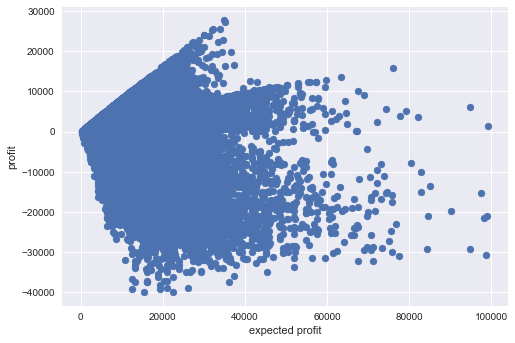

In [172]:
plt.scatter(df.expected_profit, df.profit)
plt.xlabel('expected profit')
plt.ylabel('profit')

**Make cleaning pipeline**<a name="cleaning_pipeline"></a>  
We now group our entire cleaning pipeline into the `prep_data` function in order to increase the reproducibility of our analysis.

In [173]:
def clean_data(df, state_centroid):
    df = calculate_profit(df)
    df = drop_missing_cols(df)
    df = remove_future_cols(df)
    df = clean_low_unique_values(df)
    df = drop_text_col(df)
    df, zip_codes = clean_objects(df)
    df = add_state_centroids(df, state_centroid)
    df = mean_imputation(df)
    df = add_expected_profit(df)
    return df, zip_codes

In [174]:
def prep_data(df_all, state_centroid):    
    df_all = remove_current_loans(df_all)
    df_train, df_test = sample_data(df_all)
    df_train, zip_codes_train = clean_data(df_train, state_centroid)
    df_test, zip_codes_test = clean_data(df_test, state_centroid)
    return df_train, df_test, zip_codes_train, zip_codes_test

In [181]:
df, df_test_profit, zip_codes, zip_codes_test_profit = prep_data(accepted_df, state_centroid)

In [206]:
df.head()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,earliest_cr_line,open_acc,total_acc,initial_list_status,total_rec_late_fee,application_type,total_rev_hi_lim,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_sats,pub_rec_bankruptcies,tax_liens,total_bc_limit,total_il_high_credit_limit,disbursement_method,profit,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,HOME_MORTGAGE,HOME_NONE,HOME_OTHER,HOME_OWN,HOME_RENT,Income_Source Verified,Income_Verified,purpose_car,purpose_credit_card,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,Latitude,Longitude,expected_profit
0,9000.0,1,13.11,303.73,10.0,49000.0,32.62,1999.038416,18.0,31.0,1,0.0,1,88435.0,9.0,14.0,1.0,17.0,30.0,18.0,0.0,0.0,68635.0,25000.0,1,1933.96,0,4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,35.214563,-79.891267,4024.033859
1,15000.0,0,14.33,351.60,10.0,95189.0,7.00,1999.038416,6.0,20.0,1,0.0,1,13300.0,4.0,7.0,4.0,5.0,9.0,6.0,1.0,0.0,6300.0,15021.0,1,6003.89,0,0,2,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,38.997934,-105.550567,14301.663493
2,13000.0,0,14.31,304.59,3.0,40026.0,27.35,2000.000000,12.0,30.0,0,0.0,1,12800.0,3.0,3.0,17.0,4.0,13.0,12.0,0.0,0.0,12500.0,57855.0,1,1064.62,0,0,4,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,39.766219,-86.441277,12372.570976
3,8500.0,1,13.33,287.76,2.0,40500.0,14.52,2006.000000,20.0,33.0,1,0.0,1,15900.0,5.0,5.0,24.0,9.0,9.0,20.0,0.0,0.0,8300.0,34524.0,1,1848.07,0,0,3,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39.739318,-89.504139,3872.389736
4,18000.0,0,13.67,415.76,10.0,55000.0,38.51,1998.000000,14.0,21.0,1,0.0,1,38300.0,7.0,12.0,2.0,12.0,19.0,14.0,0.0,0.0,28300.0,50469.0,1,4606.92,0,0,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.271875,-119.270415,16158.737044


We now save our clean data and zip codes for modelling and the fairness analysis

In [182]:
df.to_csv('../../data/cleanData/accepted_loans_balanced.csv')
zip_codes.to_csv('../../data/cleanData/zip_codes_balanced.csv')
df_test_profit.to_csv('../../data/cleanData/accepted_loans_unbalanced.csv')
zip_codes_test_profit.to_csv('../../data/cleanData/zip_codes_unbalanced.csv')

## Load and Clean Census Data <a name="eda_census"></a>

We use the census data supplied by the cs109 teaching staff to learn demographic proportions for 3-digit zip codes areas.

## Read the census data

In [183]:
census_df = pd.read_csv("../../data/census/census_zipcode_level.csv")
census_df.head()

def make_three_dig_zip(x):
    while len(x) < 5:
        x = '0'+x
    return x[:3]

def clean_census(df_census):
    # get only first 3 digits of zip code
    df_census['zip_3_digit'] = (df_census['Zip'].astype(str).apply(make_three_dig_zip))

    # Calculate the total number of males and females
    df_census['Female'] = df_census['Female_0to9_Years'] + df_census['Female_10to19_Years'] + df_census['Female_20to29_Years'] + df_census['Female_30to39_Years'] + df_census['Female_40to49_Years'] + df_census['Female_50to59_Years'] + df_census['Female_60to69_Years'] + df_census['Female_70p_Years']
    df_census['Male'] = df_census['Male_0to9_Years'] + df_census['Male_10to19_Years'] + df_census['Male_20to29_Years'] + df_census['Male_30to39_Years'] + df_census['Male_40to49_Years'] + df_census['Male_50to59_Years'] + df_census['Male_60to69_Years'] + df_census['Male_70p_Years']

    # Calculate the total number of older adults (>60)
    df_census['Old'] = df_census['Female_60to69_Years'] + df_census['Female_70p_Years'] + df_census['Male_60to69_Years'] + df_census['Male_70p_Years']

    # Calculate the percent of race,gender,and age variables for each three digit zip code
    protected_classes  = ['White',
                          'Black',
                          'Native',
                          'Asian',
                          'Islander',
                          'Hispanic',
                          'Male',
                          'Female',
                          'Old',
                          'Population'
                         ]
    pop_by_zip = df_census.groupby('zip_3_digit')[protected_classes].apply(lambda x : x.sum())
    
    #get proportions
    return pop_by_zip.div(pop_by_zip['Population'].values, axis = 0)

pop_by_zip = clean_census(census_df)
pop_by_zip.head()

,White,Black,Native,Asian,Islander,Hispanic,Male,Female,Old,Population
zip_3_digit,,,,,,,,,,
010,0.820283,0.024454,0.001096,0.030039,0.000328,0.106660,0.482270,0.517730,0.228364,1.0
011,0.382322,0.171680,0.001384,0.023936,0.000077,0.395235,0.472920,0.527080,0.176732,1.0
012,0.894793,0.024996,0.002029,0.015171,0.000390,0.040706,0.483081,0.516919,0.285754,1.0
013,0.915679,0.009634,0.002048,0.013876,0.000715,0.039337,0.488172,0.511828,0.259422,1.0
014,0.824253,0.025376,0.001311,0.025284,0.000000,0.102664,0.496129,0.503871,0.206169,1.0


We also save the protected class proportions for later

In [184]:
pop_by_zip.to_csv('../../data/cleanData/protected_class_proportions.csv')

## End of the EDA and Data Cleaning


## Black Box Models <a name="black_box"></a>

Before considering fairness, we will fit a series of models that purely optimize predicting profit. The models we will fit are as follows:
* Linear regression
* Linear regression with polynomial interaction terms and ridge regression
* Linear regression with polynomial interaction terms and lasso regression
* Random forest
* XGBoost regressor


In [215]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [199]:
df = pd.read_csv('../../data/cleanData/accepted_loans_balanced.csv', index_col=0)

In [200]:
X_train, X_test, y_train, y_test = (
    train_test_split(df.drop('profit', axis = 1), df['profit'], test_size=0.25, random_state=42))

In [201]:
# standardize features since some of our models are sensitive to the magnitude of coeffecients
def preprocess(X_train, X_test):
    scaler_X = StandardScaler().fit(X_train)
    X_train = scaler_X.transform(X_train)
    X_test = scaler_X.transform(X_test)
    return X_train, X_test, scaler_X
X_train, X_test, scaler = preprocess(X_train, X_test)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


**Linear Regression Baseline** <a name="linear"></a>

In [202]:
model_linear = LinearRegression()
scores_linear = cross_val_score(model_linear, X_train, y_train, cv=5)
scores_linear

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


array([0.14160372, 0.12115613, 0.13809385, 0.13606674, 0.11801127])

**Lasso Regression with 2nd degree terms** <a name="lasso"></a>

In [203]:
# get 2nd degree polynomial features
poly_2 = PolynomialFeatures(2)
X_train_poly = poly_2.fit_transform(X_train)
X_train_poly.shape[1]

1596

In [204]:
# Lasso Polynomial Features
model_lasso = LassoCV(cv = 5)
scores_lasso = cross_val_score(model_lasso, X_train, y_train, cv=5)
scores_lasso

array([0.14109306, 0.12137329, 0.13872868, 0.1353839 , 0.1186947 ])

**Ridge Polynomial with 2nd degree terms** <a name="ridge"></a>

In [221]:
# ridge polynomial features
model_ridge= RidgeCV(cv = 5)
scores_ridge = cross_val_score(model_ridge, X_train_poly, y_train, cv=5)
scores_ridge

array([ 9.85048320e-02, -8.55203350e+01,  1.04364676e-01,  1.08236795e-01,
        5.96243998e-02])

**Random Forest**  <a name="rf"></a>

To train our random forest model, we rely heavily on this [guide to hyperparameter tuning](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

In [35]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(start = 3, stop = X_train.shape[1], num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': [3, 9, 15, 21, 27, 33, 39, 45, 51, 57], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [36]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=5, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 117.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 123.2min finished
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': [3, 9, 15, 21, 27, 33, 39, 45, 51, 57], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=5)

In [37]:
rf_random.best_params_

{'n_estimators': 350,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 15,
 'max_depth': 10,
 'bootstrap': False}

results of random search:  
`{'n_estimators': 350,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 15,
 'max_depth': 10,
 'bootstrap': False}`

In [52]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 10, 12],
    'max_features': [13,15,17],
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'n_estimators': [330, 350, 370]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 3)

In [53]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train.ravel())
grid_search.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 12.2min finished


{'bootstrap': True,
 'max_depth': 12,
 'max_features': 17,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 350}

Result of CV:
`{'bootstrap': True,
 'max_depth': 12,
 'max_features': 17,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 350}`

In [210]:
model_rf = RandomForestRegressor(max_depth = 12, 
                                max_features = 17,
                                min_samples_leaf=2, 
                                min_samples_split=2,
                                n_estimators=350)

In [209]:
scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5)
scores_rf

array([0.17104292, 0.15113774, 0.1679915 , 0.16467426, 0.15045807])

In [211]:
model_rf = model_rf.fit(X_train, y_train)

In [212]:
importances_rf = pd.DataFrame({'importance':model_rf.feature_importances_,
                               'feature':df.drop('profit', axis = 1).columns})
importances_rf.sort_values(by = 'importance',ascending = False)

,importance,feature
54,0.174094,expected_profit
3,0.081623,installment
0,0.079864,loan_amnt
7,0.067298,earliest_cr_line
2,0.055299,int_rate
6,0.047856,dti
5,0.039866,annual_inc
13,0.035537,total_rev_hi_lim
22,0.034588,total_bc_limit
23,0.030562,total_il_high_credit_limit


**xgboost** <a name="xgboost"></a>

To set the initial ranges of our hyperparameter tuning, we follow this [guide to hyperparameter tuning for xgboost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [43]:
max_depth = [int(x) for x in np.linspace(start = 3, stop = 10, num = 7)]
learning_rate = [0.05,0.1,0.3]
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
gamma = [int(x) for x in np.linspace(start = 0, stop = 0.5, num = 5)]
min_child_weight = [int(x) for x in np.linspace(start = 1, stop = 6, num = 5)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }
print(random_grid)

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': [3, 9, 15, 21, 27, 33, 39, 45, 51, 57], 'max_depth': [3, 4, 5, 6, 7, 8, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [44]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xg = XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xg_random = RandomizedSearchCV(estimator = xg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=5, random_state=42, n_jobs = -1)
# Fit the random search model
xg_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 55.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 146.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 259.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 283.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': [3, 9, 15, 21, 27, 33, 39, 45, 51, 57], 'max_depth': [3, 4, 5, 6, 7, 8, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=5)

In [45]:
xg_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 39,
 'max_depth': 4}

result of random cv:  
`{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 39,
 'max_depth': 4}`

In [82]:
param_grid = {
    'max_depth': [3,4,5],
    'max_features': [35, 40, 45],
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'n_estimators': [100, 200, 300]
}
# Create a based model
xg = XGBRegressor()
# Instantiate the grid search model
grid_search_xg = GridSearchCV(estimator = xg, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 3)

In [83]:
# Fit the grid search to the data
grid_search_xg.fit(X_train, y_train)
grid_search_xg.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 10.7min finished


{'max_depth': 3,
 'max_features': 35,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

result of cv:
`{'max_depth': 3,
 'max_features': 35,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}`

In [216]:
model_xg = XGBRegressor(max_depth = 3,
                       max_features = 35,
                       min_samples_leaf = 2,
                       min_samples_split = 2,
                       n_estimators = 100)

In [218]:
scores_xg = cross_val_score(model_xg, X_train, y_train, cv=5)
scores_xg

array([0.17087948, 0.15394619, 0.1636027 , 0.16872147, 0.14434699])

In [219]:
model_xg = model_xg.fit(X_train, y_train)

## Plot Model Results  <a name="plots"></a>

In [227]:
scores = [scores_linear, scores_lasso, scores_ridge, scores_rf, scores_xg]
scores_clean = []
for model_score in scores:
    scores_clean.append([score for score in model_score if abs(score)<5])

scores_mean = np.array([np.mean(model_score) for model_score in scores_clean])
scores_std = np.array([np.std(model_score) for model_score in scores_clean])

In [228]:
scores_mean

array([0.13098634, 0.13105473, 0.09268268, 0.1610609 , 0.16029937])

In [229]:
scores_std

array([0.00952934, 0.00921846, 0.01939811, 0.00862113, 0.00988559])

Summary of the results <a name="summary"></a>

Text(0.5,1,'The Performance of the Models in 5 Fold Cross-Validation ')

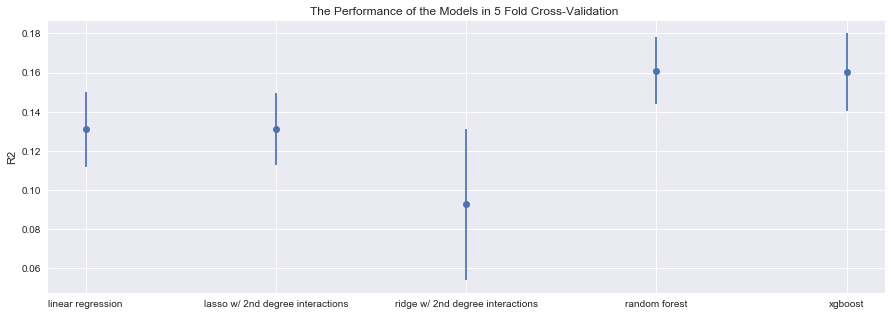

In [230]:
plt.figure(figsize = (15,5))
plt.errorbar(range(len(scores_mean)), scores_mean, yerr = 2*scores_std, fmt = 'o')
plt.xticks(range(len(scores_mean)),
           ["linear regression", 
            "lasso w/ 2nd degree interactions",
            "ridge w/ 2nd degree interactions",
            "random forest",
            "xgboost"])
plt.ylabel("R2")
plt.title('The Performance of the Models in 5 Fold Cross-Validation ')

**Performance of XGBoost on test set** <a name="focus_xg"></a>


In [231]:
from sklearn.metrics import r2_score

In [233]:
final_test_set_score = r2_score(model_xg.predict(X_test), y_test)
print("XGBoost r2 score on test set:", final_test_set_score)

XGBoost r2 score on test set: -4.6003256927371705


It looks like our model is overfitting our cross validation.

**Assessing Profitability**  

Now we study how profitable our models are on a new dataset of 50 000 loans that has not been balanced between fully paid and defautled loans. Our investment stategy is to invest in all loans that are predicted to yield a positive return.

In [275]:
df_profit = pd.read_csv('../../data/cleanData/accepted_loans_unbalanced.csv',index_col=0)

In [276]:
X_profit, y_profit = df_profit.drop('profit', axis = 1), df_profit['profit']

In [277]:
X_profit = scaler.transform(X_profit)

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [278]:
y_profit_predictions = model_xg.predict(X_profit)

In [279]:
np.mean(y_profit[y_profit_predictions > 0])

474.9319524281467

In [293]:
np.mean(y_profit[y_profit_predictions > 0])/df_profit[y_profit_predictions > 0].loan_amnt.mean()

0.05817746684917704

In [280]:
np.mean(y_profit)

277.47272080000005

In [292]:
np.mean(y_profit)/df_profit.loan_amnt.mean()

0.019508857245106665

Our maximum profit model leads to an average return of 474 dollars per investment, which can be compared to a return of 277 dollars per investment if we just invested randomly.

## Feature Importance From Linear Regression  <a name="feature_importance"></a>

XGBoost does not yeild interpretable models, so we perform a lasso regression with a high regularization penalty to select the features most correlated with profits.

In [150]:
model_lasso_fit = Lasso(alpha = 100).fit(X_train, y_train)

Text(0.5,1,'Coefficient Value for Lasso Regression')

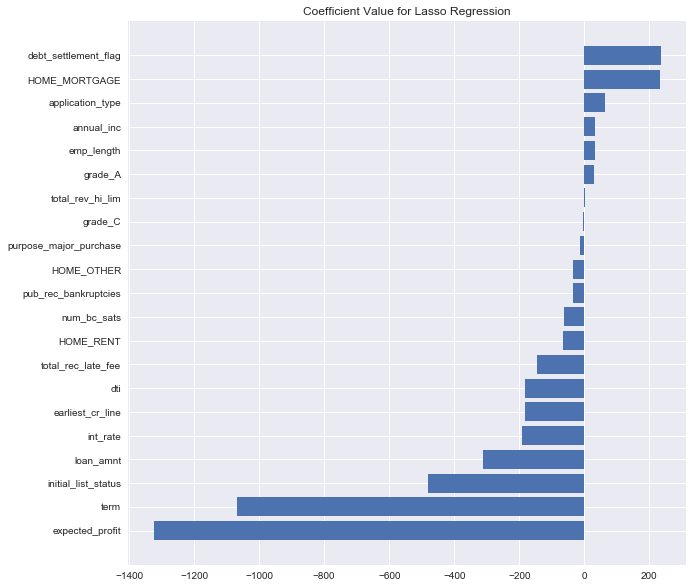

In [170]:
coefs = pd.DataFrame({"coef":model_lasso_fit.coef_, "feature":df.drop('profit', axis = 1).columns})
non_zero_coef = coefs[coefs.coef != 0].sort_values(by = 'coef')
plt.figure(figsize = (10,10))
plt.barh(non_zero_coef.feature, non_zero_coef.coef)
plt.title('Coefficient Value for Lasso Regression')

**Interpretation of Profit Investment Strategy (ignoring fairness)**

Invest if the borrower:
* mortgages their home
* is applying individually
* has a high income
* has been employed for a long time
* has a grade A loan

Do not invest if the borrower:
* has a 60 term loan
* has the loan listed as a ["whole loan"](https://blog.lendingclub.com/investor-updates-and-enhancements/)
* is asking for a large loan
* has a high interest rate
* has had a credit line for a long time
* has a high debt to income ratio

# Fairness <a name="fairness"></a>

Now we will explore trade-offs between profitability and fairness. We will use a predictive parity approach to fairness. We choose predictive parity over statistical parity because achieving statistical parity requires giving out explicitly unprofitable loans. In other words, some groups will be getting loans that they default on, which can lead to long term financial struggles and increased stress. 

Predictive parity ensures that _error rates_ between protected classes and the general population are equivalent. This means that we want to identify safe loans when disadvantaged individuals request them.

To make sure that our model respects predictive parity, we will add a regularizer to our loss function. [Bechavod and Ligett](https://arxiv.org/pdf/1706.02409.pdf) take this approach, but in a binary classification context. [Berk et al](https://arxiv.org/pdf/1706.02409.pdf) extend this method to regression, but they only look at group (statistical) fairness and individual fairness. From our literature review, we appear to be the first to define a predictive parity regularizer in a regression context. 

Let $\hat{y}_{all}$ be our profit predictions for everyone. Let $\hat{y}_{protected}$ be our profit predictions for a protected class. Likewise, $y_{all}$ and $y_{protected}$ are the corresponding ground truth profits. Our "fair" loss function is,

$$
L(\hat{y}_{all},y_{all},\hat{y}_{protected},y_{protected}) = \text{MSE}(\hat{y}_{all},y_{all}) + \alpha \left(\text{MSE}(\hat{y}_{all},y_{all})-\text{MSE}(\hat{y}_{protected},y_{protected})\right)^2
$$

where $\alpha$ is a tuning parameter for the regularizer. The first term in the loss function corresponds to the usual mean squared error. The second term is the predictive parity regularizer, which penalizes the model when there is a difference between the mean squared error in the protected group and the population overall.

## Add Protected Classes to Loan Data via Sampling <a name="protected"></a>

To link the census proportions to the lending data, we treat the demographic proportions as the parameters of a categorical probability distribution. For each individual in our lending dataset, we sample their demographic information from the distributions corresponding to their zip code. 

In [ ]:
zip_codes_df = pd.DataFrame(zip_codes)
zip_codes_df.head()

**Sample races**

In [ ]:
def clean_zipcode(x):
    x = x.replace("xx","")
    while len(x)<3:
        x = '0'+x
    return x
zip_codes_df['zip_code'] = zip_codes_df['zip_code'].apply(clean_zipcode)

In [ ]:
zip_codes_df

In [ ]:
races = ["White","Black",'Native','Asian','Islander','Hispanic']
race_by_zip = pop_by_zip[races]

In [ ]:
def sample_race(x):
    zipcode = x['zip_code']
    race_dist = race_by_zip[race_by_zip.index == zipcode].values
    race_dist = race_dist/np.sum(race_dist)
    try:
        race_dist = race_dist[0,:]
        race_sample = np.random.multinomial(1, race_dist)
        for idx, r in enumerate(races):
            x[r] = race_sample[idx]
    except IndexError:
        for idx, r in enumerate(races):
            x[r] = 0
    return x

In [ ]:
zip_codes_df = zip_codes_df.apply(sample_race, axis = 1)

In [ ]:
def sample_gender(x):
    zipcode = x['zip_code']
    p_female = pop_by_zip[pop_by_zip.index == zipcode]['Female'].values
    if p_female > np.random.uniform(0,1):
        female_sample = 1
    else:
        female_sample = 0
    x["female"] = female_sample
    return x

In [ ]:
zip_codes_df = zip_codes_df.apply(sample_gender, axis = 1)

In [ ]:
def sample_age(x):
    zipcode = x['zip_code']
    p_old = pop_by_zip[pop_by_zip.index == zipcode]['Old'].values
    if p_old > np.random.uniform(0,1):
        old_sample = 1
    else:
        old_sample = 0
    x["old"] = old_sample
    return x

In [ ]:
zip_codes_df = zip_codes_df.apply(sample_age, axis = 1)

## fair linear regression <a name="fair_linear"></a>

We use pytorch to define our custom loss function. This restricts us to linear regression, which as we saw above achieves low profitability, and neural networks.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torch.nn.modules import Module
from sklearn.metrics import r2_score

In [ ]:
X_train, X_test, y_train, y_test, protected_train, protected_test = train_test_split(df.drop('profit', axis = 1), df['profit'], zip_codes_df, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val, protected_train, protected_val = train_test_split(X_train, y_train, protected_train, test_size=0.25, random_state=42)


In [ ]:
def preprocess(X_train, X_val, X_test, y_train, y_val, y_test):
    scaler_X = StandardScaler().fit(X_train)
    X_train = scaler_X.transform(X_train)
    X_val = scaler_X.transform(X_val)
    X_test = scaler_X.transform(X_test)
    scaler_y = StandardScaler().fit(y_train.values.reshape(-1,1))
    y_train = scaler_y.transform(y_train.values.reshape(-1,1))
    y_val = scaler_y.transform(y_val.values.reshape(-1,1))
    y_test = scaler_y.transform(y_test.values.reshape(-1,1))
    return X_train, X_val, X_test, y_train, y_val, y_test
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(X_train, X_val, X_test, y_train, y_val, y_test)

In [ ]:
class Data(Dataset):
    def __init__(self, X_train, y_train, classes):
        self.x = Variable(torch.from_numpy(X_train)).float()
        self.y = Variable(torch.from_numpy(y_train)).float()
        self.classes = torch.Tensor(list(classes.values == 1))==True
        self.len = self.x.shape[0]
    def __getitem__(self,index):    
        return self.x[index], self.y[index], self.classes[index]
    def __len__(self):
        return self.len

In [ ]:
class LinearRegressionPytorch(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
class FairMAE(Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, outputs, labels, classes):  
        mae = nn.L1Loss(reduce = True)
        if 1 in classes:         
            protected_outputs = outputs[classes]
            protected_labels = labels[classes]
            total_mae = mae(outputs, labels)
            protected_mae = mae(protected_outputs, protected_labels)
            return total_mae + self.alpha*(protected_mae - total_mae)**2, total_mae, protected_mae
        else:
            total_mae = mae(outputs, labels)
            return total_mae, protected_mae, None

In [ ]:
def fit_linear_regression(X_train, y_train, protected_class, batch_size = 25, alpha = 0, lr = 0.01):
    model = LinearRegressionPytorch(X_train.shape[1])
    criterion = FairMSE(alpha)
    optimiser = torch.optim.Adam(model.parameters(), lr = lr) #Stochastic Gradient Descent
    epochs = 100
    
    inputs_all = Variable(torch.from_numpy(X_train)).float()
    labels_all = Variable(torch.from_numpy(y_train)).float()
    classes_all = torch.Tensor(list(protected_class.values == 1))==True
    
    dataset=Data(X_train, y_train, protected_class)
    trainloader=DataLoader(dataset = dataset, batch_size = batch_size)
    
    for epoch in range(epochs):
        for x, y, classes in trainloader:
            optimiser.zero_grad()
            outputs = model.forward(x)
            loss, total_mse, protected_mse = criterion(outputs, y, classes)
            loss.backward()# back props
            optimiser.step()# update the parameters
        outputs_all = model.forward(inputs_all)
        loss, total_mse, protected_mse = criterion(outputs_all, labels_all, classes_all)
        print("epoch: {}, Total MSE: {}, Protected MSE: {}, loss: {}".format(epoch, total_mse, protected_mse, loss))
    return model, total_mse, protected_mse

In [ ]:
model, total_mse, protected_mse = fit_linear_regression(X_train, y_train, protected_train['Hispanic'],
                                                        lr = 1e-5,
                                                        batch_size = 5,
                                                        alpha = 10
                                                       )

In [ ]:
print('train r2:',r2_score(model(Variable(torch.from_numpy(X_train)).float()).detach().numpy(), y_train))
print('validation r2:',r2_score(model(Variable(torch.from_numpy(X_val)).float()).detach().numpy(), y_val))

**Fair Multi-Layer Perceptron** <a name="fair_mlp"></a>

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, n_hidden):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_dim, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.hidden3 = nn.Linear(n_hidden, n_hidden)
        self.hidden4 = nn.Linear(n_hidden, n_hidden)
        self.out   = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = self.out(x)
        return x

In [ ]:
def fit_MLP(X_train, y_train, protected_class, batch_size = 32, alpha = 0, lr = 0.01):
    model = MLP(X_train.shape[1], 16)
    criterion = FairMSE(alpha)
    optimiser = torch.optim.Adam(model.parameters(), lr) #Stochastic Gradient Descent
    epochs = 500
    
    inputs_all = Variable(torch.from_numpy(X_train)).float()
    labels_all = Variable(torch.from_numpy(y_train)).float()
    classes_all = torch.Tensor(list(protected_class.values == 1))==True
    
    dataset=Data(X_train, y_train, protected_class)
    trainloader=DataLoader(dataset = dataset, batch_size = batch_size)
    
    for epoch in range(epochs):
        for x, y, classes in trainloader:
            optimiser.zero_grad()
            outputs = model.forward(x)
            loss, total_mse, protected_mse = criterion(outputs, y, classes)
            loss.backward()# back props
            optimiser.step()# update the parameters
        outputs_all = model.forward(inputs_all)
        loss, total_mse, protected_mse = criterion(outputs_all, labels_all, classes_all)
        print("epoch: {}, Total MSE: {}, Protected MSE: {}, loss: {}".format(epoch, total_mse, protected_mse, loss))
    return model, total_mse, protected_mse

In [ ]:
model, total_mse, protected_mse = fit_MLP(X_train, y_train, protected_train['Hispanic'], alpha = 1, lr = 1e-3)

In [ ]:
print('train r2:',r2_score(model(Variable(torch.from_numpy(X_train)).float()).detach().numpy(), y_train))
print('validation r2:',r2_score(model(Variable(torch.from_numpy(X_val)).float()).detach().numpy(), y_val))

In [ ]:
plt.scatter(y_train, model(Variable(torch.from_numpy(X_train)).float()).detach().numpy())